In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import Sim
from mdetsims.dbsim import ErinsDBSim

import sep
from mdetsims.defaults import SX_CONFIG
import scipy.spatial
import tqdm

In [6]:
def run_sep(mbobs):
    sx_config = {}
    sx_config.update(SX_CONFIG)
    sx_config['filter_kernel'] = np.array(sx_config['filter_kernel'])

    # this isn't a keyword
    detect_thresh = sx_config.pop('detect_thresh')
    detnoise = np.sqrt(1.0 / mbobs[0][0].weight)
    objs, seg = sep.extract(
        mbobs[0][0].image,
        detect_thresh,
        err=detnoise,
        segmentation_map=True,
        **sx_config
    )
    return objs

In [7]:
vals = []
for _ in tqdm.trange(200):
    sim = Sim(
        rng=np.random.RandomState(),
        g1=0.02,
        scale=0.263,
        gal_type='exp',
        psf_type='gauss',
        n_coadd=30)

    mbobs = sim.get_mbobs()

    objs = run_sep(mbobs)

    pos = np.stack([objs['x'] * 0.263, objs['y'] * 0.263]).T
    tree = scipy.spatial.cKDTree(pos)

    minds = []
    for i in range(pos.shape[0]):
        d, _ = tree.query(pos[i], k=[2])
        minds.append(d)
    vals.append(np.min(minds))

100%|██████████| 200/200 [00:28<00:00,  7.10it/s]


Text(0.5, 0, 'min source sep. [arcsec]')

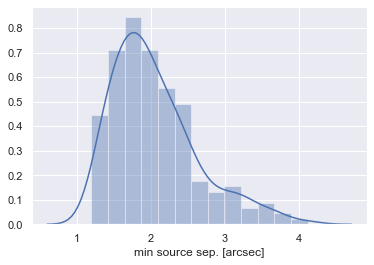

In [13]:
plt.figure()
sns.distplot(vals)
plt.xlabel('min source sep. [arcsec]')

In [14]:
np.min(vals)

1.1951284376249047

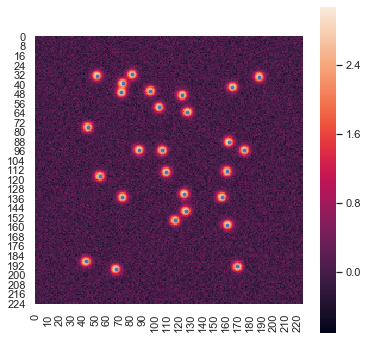

In [19]:
sim = Sim(
    rng=np.random.RandomState(),
    g1=0.02,
    scale=0.263,
    gal_type='exp',
    psf_type='gauss',
    n_coadd=30,
    gal_kws={'min_dist': 2.0}
)

mbobs = sim.get_mbobs()

objs = run_sep(mbobs)

plt.figure(figsize=(6, 6))
sns.heatmap(np.arcsinh(mbobs[0][0].image/np.std(mbobs[0][0].image[0:100])), square=True)

for i in range(objs.size):
    plt.plot(objs['x'][i], objs['y'][i], 'b.')

In [ ]:
sim = ErinsDBSim(rng=np.random.RandomState(seed=100), g1=0.02, g2=0, gal_kws={'survey_name': 'LSST'})

In [ ]:
mbobs = sim.get_mbobs()

In [ ]:
plt.figure()
sns.heatmap(np.arcsinh(mbobs[0][0].image/np.std(mbobs[0][0].image[0:100])), square=True)

In [ ]:
lsst_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.2,
    dim=300,
    buff=25,
    psf_type='gauss',
    n_coadd=300,
    n_coadd_psf=1,
    psf_kws={'fwhm': 0.7},
    gal_kws={'survey_name': 'LSST'})

erins_riz_lsst_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.2,
    dim=300,
    buff=25,
    psf_type='wldeblend',
    n_coadd=1,
    n_coadd_psf=1,
    psf_kws={'fwhm': 0.7},
    gal_kws={'survey_name': 'LSST', 'use_wldeblend_depth': True})

erins_lsst_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.2,
    dim=300,
    buff=25,
    psf_type='wldeblend',
    n_coadd=1,
    n_coadd_psf=1,
    psf_kws={'fwhm': 0.7},
    gal_kws={'survey_name': 'LSST', 'use_wldeblend_depth': True, 'bands': ('g', 'r', 'i')})

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

erins_riz_lsst_mbobs = erins_riz_lsst_sim.get_mbobs()
erins_lsst_mbobs = erins_lsst_sim.get_mbobs()
lsst_mbobs = lsst_sim.get_mbobs()

for row in range(3):
    ax = axs[row, 0]
    ax.imshow(np.arcsinh(erins_lsst_mbobs[row][0].image/erins_lsst_sim.noise[row]))
    ax.grid(False)
    if row == 0:
        ax.set_title("Erin's LSST")

    ax = axs[row, 1]
    ax.imshow(np.arcsinh(lsst_mbobs[row][0].image/lsst_sim.noise[row]))
    ax.grid(False)
    if row == 0:
        ax.set_title("Matt's LSST")

In [ ]:
erins_lsst_sim.noise

In [ ]:
erins_riz_lsst_sim.noise

In [ ]:
lsst_sim.noise

In [ ]:
from mdetsims.metacal import MetacalPlusMOF
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG

In [ ]:
import logging
import sys

for lib in ['ngmix', 'metadetect', 'mdetsims']:
    lgr = logging.getLogger(lib)
    hdr = logging.StreamHandler(sys.stdout)
    hdr.setFormatter(logging.Formatter(logging.BASIC_FORMAT))
    lgr.setLevel(logging.DEBUG)
    lgr.addHandler(hdr)


In [ ]:
lsst_mcal = MetacalPlusMOF(TEST_METACAL_MOF_CONFIG, lsst_mbobs, np.random.RandomState(seed=10))
lsst_mcal.go()

In [ ]:
erins_lsst_mcal = MetacalPlusMOF(TEST_METACAL_MOF_CONFIG, erins_lsst_mbobs, np.random.RandomState(seed=10))
erins_lsst_mcal.go()

In [ ]:
erins_riz_lsst_mcal = MetacalPlusMOF(TEST_METACAL_MOF_CONFIG, erins_riz_lsst_mbobs, np.random.RandomState(seed=10))
erins_riz_lsst_mcal.go()

In [ ]:
d = lsst_mcal.result['mof']
ed = erins_lsst_mcal.result['mof']
erizd = erins_riz_lsst_mcal.result['mof']

In [ ]:
plt.figure()
sns.distplot(np.log10(d['bdf_s2n']), label='Matt mean log10(s/n): %f' % np.mean(np.log10(d['bdf_s2n'])))
sns.distplot(np.log10(ed['bdf_s2n']), label='Erin gri mean log10(s/n): %f' % np.mean(np.log10(ed['bdf_s2n'])))
sns.distplot(np.log10(erizd['bdf_s2n']), label='Erin riz mean log10(s/n): %f' % np.mean(np.log10(erizd['bdf_s2n'])))
plt.xlabel('log10(s/n)')
plt.legend()

In [ ]:
import os
os.environ['CATSIM_DIR'] = '/Users/Matt/CATSIM_DIR'

des_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.263,
    psf_type='ps',
    n_coadd=10 * 3,
    n_coadd_psf=10,
    psf_kws={'trunc': 1, 'median_seeing': 0.8},
    gal_kws={'survey_name': 'DES'})

lsst_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.2,
    # we have to adjust these so we get a patch that is the same size in LSST
    # in order to compare the simulations
    dim=300,
    buff=25,
    psf_type='ps',
    n_coadd=1,
    n_coadd_psf=1,
    psf_kws={'trunc': 1, 'median_seeing': 0.6},
    gal_kws={'survey_name': 'LSST'})

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

des_mbobs = des_sim.get_mbobs()
lsst_mbobs = lsst_sim.get_mbobs()

ax = axs[0, 0]
ax.imshow(np.arcsinh(des_mbobs[0][0].image/des_sim.noise))
ax.grid(False)
ax.set_title('DES')

ax = axs[0, 1]
ax.imshow(np.arcsinh(lsst_mbobs[0][0].image/lsst_sim.noise))
ax.grid(False)
ax.set_title('LSST')

ax = axs[1, 0]
ax.imshow(des_mbobs[0][0].noise)
ax.grid(False)

ax = axs[1, 1]
ax.imshow(lsst_mbobs[0][0].noise)
ax.grid(False)

ax = axs[2, 0]
ax.imshow(des_mbobs[0][0].bmask)
ax.grid(False)

ax = axs[2, 1]
ax.imshow(lsst_mbobs[0][0].bmask)
ax.grid(False)

In [ ]:
psf_obs1 = sim.get_psf_obs(x=0, y=30)
psf_obs2 = sim.get_psf_obs(x=10, y=120)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.heatmap(psf_obs1.image, square=True, ax=axs[0])

sns.heatmap((psf_obs2.image - psf_obs1.image) / np.max(psf_obs1.image), square=True, ax=axs[1])

In [ ]:
from mdetsims.masking import generate_bad_columns, generate_cosmic_rays

fig, axs = plt.subplots(nrows=3, ncols=3, sharex='all', sharey='all', figsize=(10, 10))

for ax in axs.ravel():
    msk = np.zeros((225, 225)).astype(bool)
    msk |= generate_cosmic_rays(msk.shape)
    msk |= generate_bad_columns(msk.shape)
    ax.imshow(1-msk, vmin=0, vmax=1)
    ax.grid(False)

In [ ]:
des_sim.nobj

In [ ]:
lsst_sim.nobj

In [ ]:
import galsim

p0 = des_sim._psfs[0].getPSF(galsim.PositionD(x=10, y=10))
p1 = des_sim._psfs[1].getPSF(galsim.PositionD(x=10, y=10))

In [ ]:
p0im = p0.drawImage(scale=0.263)

In [ ]:
p = galsim.Sum([p.getPSF(galsim.PositionD(x=10, y=10)) for p in des_sim._psfs])

In [ ]:
pim = p.drawImage(scale=0.263)

In [ ]:
galsim.hsm.FindAdaptiveMom(p0im)

In [ ]:
galsim.hsm.FindAdaptiveMom(pim)

In [ ]:
from mdetsims.metacal import MetacalPlusMOF
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG

In [ ]:
lsst_mbobs = lsst_sim.get_mbobs()

In [ ]:
mcal = MetacalPlusMOF(TEST_METACAL_MOF_CONFIG, lsst_mbobs, np.random.RandomState(seed=10))

In [ ]:
mcal.go()

In [ ]:
cat = mcal.result

In [ ]:
cat.keys()

In [ ]:
d = cat['mof']

In [ ]:
d.dtype

In [ ]:
msk = d['flags'] == 0